<a href="https://colab.research.google.com/github/julianacholder/ATS-Match-ML-Powered-Resume-Job-Matching-System/blob/main/Juliana_Holder_MLOP_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATS-Match: ML-Powered Resume-Job Matching System

## Project Overview
This notebook demonstrates an AI-powered Applicant Tracking System that predicts the relevance of resumes for specific job postings using machine learning. The system combines text processing, neural networks, and database integration to create a complete ML deployment pipeline.

### Key Features
- Resume-job matching prediction
- Data visualization for feature analysis
- Database integration for data storage
- Model retraining capability
- Complete deployment pipeline

The workflow includes data preprocessing, TF-IDF vectorization, neural network prediction, and model evaluation, all deployable via a Flask application with Docker containerization.

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import sqlite3
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
# Import custom modules from src folder
from src.preprocessing import preprocess_data, vectorize_data, split_and_save_data, handle_class_imbalance, parse_resume
from src.model import load_keras_model, evaluate_model, plot_confusion_matrix, save_model, plot_training_history, train_model
from src.prediction import predict_single, predict_batch, generate_detailed_report

In [27]:
# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

In [28]:
# Define database path
DATABASE_PATH = 'data/ats_database.db'
TABLE_NAME = 'resume_job_matches'

In [29]:
# Load data from CSV first (for initial setup)
try:
    df = pd.read_csv('resume_data.csv')
except pd.errors.ParserError:
    print("Encountered parsing error - trying with error handling")
    df = pd.read_csv('resume_data.csv',
                     on_bad_lines='skip',
                     warn_bad_lines=True)
    print(f"Loaded {len(df)} rows with skipping bad lines")

print(f"CSV data loaded with shape: {df.shape}")

CSV data loaded with shape: (9544, 35)


In [30]:
# Create and connect to SQLite database
conn = sqlite3.connect(DATABASE_PATH)

# Store the data in the database
df.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
print(f"Data saved to database: {DATABASE_PATH}, table: {TABLE_NAME}")

#loading data from database
print("Loading dataset from database...")
query = f"SELECT * FROM {TABLE_NAME}"
df = pd.read_sql(query, conn)

conn.close()
print(f"Dataset loaded from database with shape: {df.shape}")

Data saved to database: data/ats_database.db, table: resume_job_matches
Loading dataset from database...
Dataset loaded from database with shape: (9544, 35)


In [31]:
print("\nSample data:")
print(df.head())


Sample data:
  address  ... matched_score
0    None  ...      0.850000
1    None  ...      0.750000
2    None  ...      0.416667
3    None  ...      0.760000
4    None  ...      0.650000

[5 rows x 35 columns]


In [32]:
# Show columns
print("\nColumns in dataset:")
print(df.columns.tolist())


Columns in dataset:
['address', 'career_objective', 'skills', 'educational_institution_name', 'degree_names', 'passing_years', 'educational_results', 'result_types', 'major_field_of_studies', 'professional_company_names', 'company_urls', 'start_dates', 'end_dates', 'related_skils_in_job', 'positions', 'locations', 'responsibilities', 'extra_curricular_activity_types', 'extra_curricular_organization_names', 'extra_curricular_organization_links', 'role_positions', 'languages', 'proficiency_levels', 'certification_providers', 'certification_skills', 'online_links', 'issue_dates', 'expiry_dates', '\ufeffjob_position_name', 'educationaL_requirements', 'experiencere_requirement', 'age_requirement', 'responsibilities.1', 'skills_required', 'matched_score']


In [33]:
# Show basic statistics
print("\nBasic statistics:")
print(df.describe())


Basic statistics:
       matched_score
count    9544.000000
mean        0.660831
std         0.167040
min         0.000000
25%         0.583333
50%         0.683333
75%         0.793333
max         0.970000



Class distribution (1 = Relevant, 0 = Not Relevant):
matched_score
0    5075
1    4469
Name: count, dtype: int64


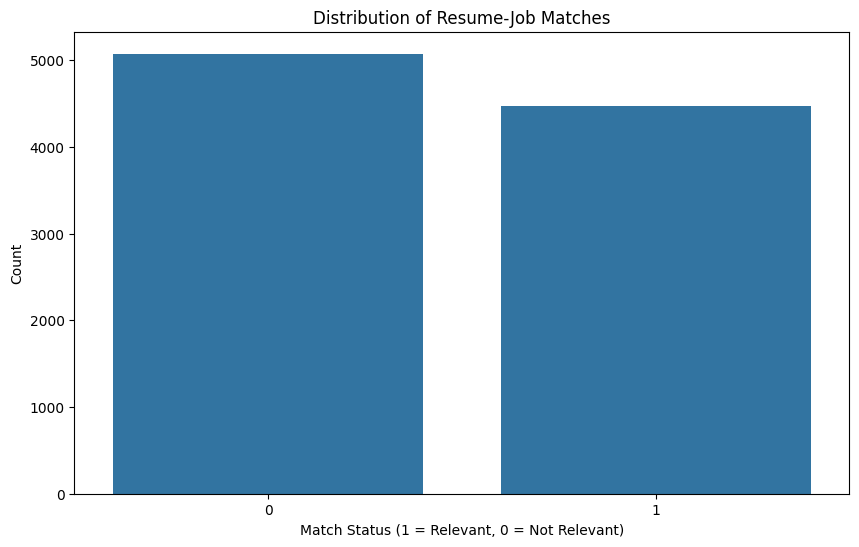

In [34]:
# class distribution
matched_scores = df['matched_score']
binary_matches = (matched_scores >= 0.7).astype(int)
print("\nClass distribution (1 = Relevant, 0 = Not Relevant):")
print(binary_matches.value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=binary_matches)
plt.title('Distribution of Resume-Job Matches')
plt.xlabel('Match Status (1 = Relevant, 0 = Not Relevant)')
plt.ylabel('Count')
plt.show()

## Class Distribution of Resume-Job Matches

This bar chart shows the distribution of labels in the dataset.

- Class `0` (Not Relevant) slightly outnumbers class `1` (Relevant).
- The distribution is fairly balanced, with no major class imbalance.

In [35]:
# Data Preprocessing
# ====================
print("\nPreprocessing data...")
processed_df = preprocess_data(df)  #function from the preprocessing.py file

# Display processed data
print("\nProcessed data sample:")
print(processed_df[['resume_text', 'job_text', 'job_match']].head(2))

# Split and save data
train_path, test_path = split_and_save_data(processed_df)

# Load train/test data to confirm
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


Preprocessing data...

Processed data sample:
                                         resume_text  ... job_match
0  Big data analytics working and database wareho...  ...         1
1  Fresher looking to join as a data analyst and ...  ...         1

[2 rows x 3 columns]
Training data saved to data/train/train_data.csv (7635 samples)
Test data saved to data/test/test_data.csv (1909 samples)


In [36]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (7635, 39)
Test data shape: (1909, 39)


In [66]:

# Feature Extraction with TF-IDF
# ================================
print("\nExtracting features with TF-IDF...")

# Create a new vectorizer with exactly 3318 features
print("Creating TF-IDF vectorizer with 3318 features...")
vectorizer = TfidfVectorizer(stop_words='english', max_features=3318)
X_features = vectorizer.fit_transform(processed_df['combined']).toarray()

# Confirm the shape
print(f"Feature shape: {X_features.shape}")

# Get labels
y = processed_df['job_match'].values

feature_names = vectorizer.get_feature_names_out()



Extracting features with TF-IDF...
Creating TF-IDF vectorizer with 3318 features...
Feature shape: (9544, 3318)


In [62]:
relevant_indices = np.where(y == 1)[0]
non_relevant_indices = np.where(y == 0)[0]

# Calculate average TF-IDF values for relevant and non-relevant matches
relevant_avg = X_features[relevant_indices].mean(axis=0)
non_relevant_avg = X_features[non_relevant_indices].mean(axis=0)

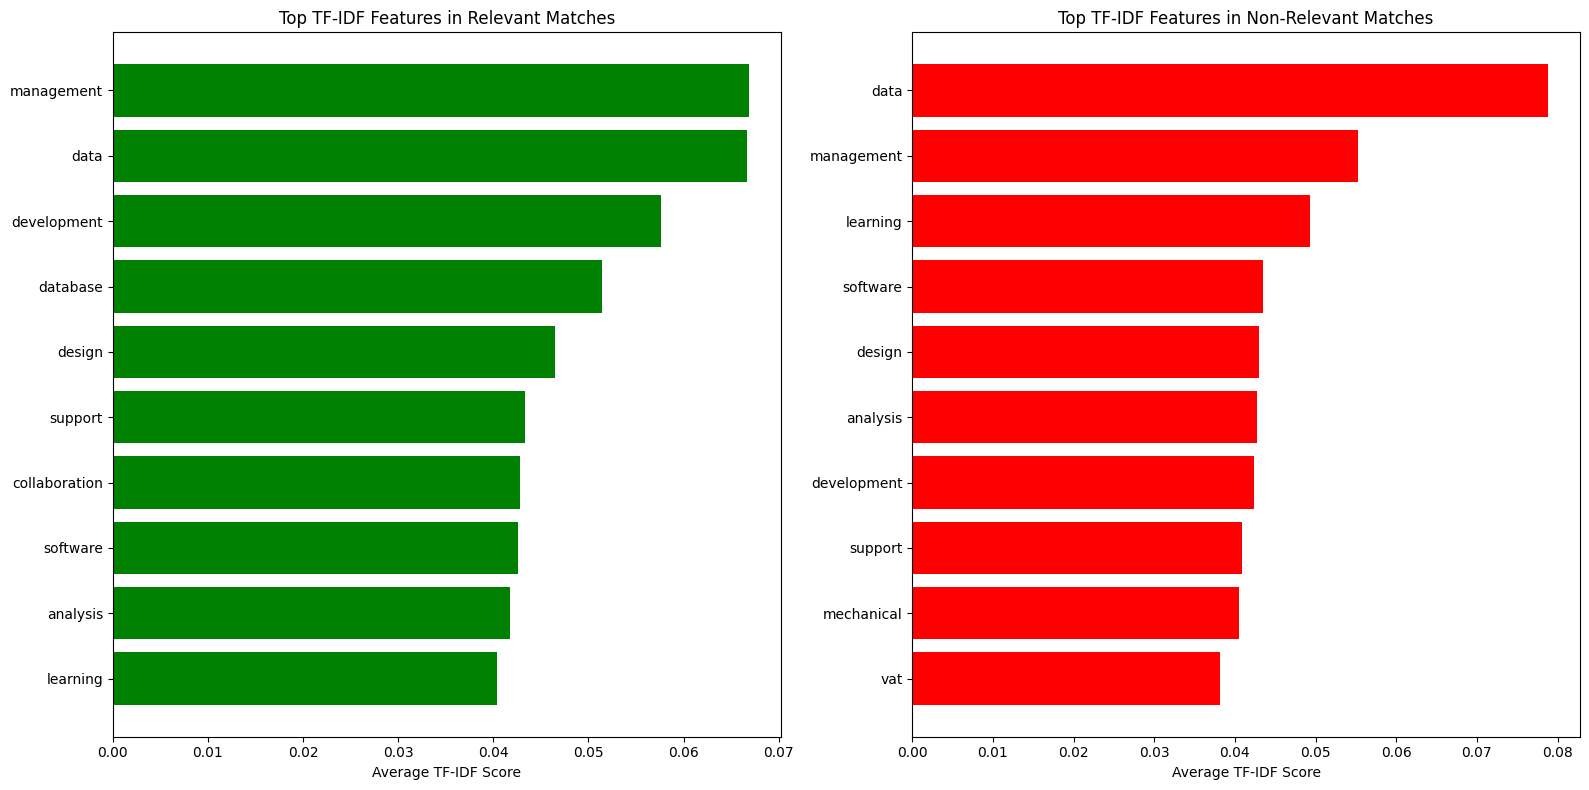

In [63]:
def get_top_features(feature_values, feature_names, top_n=10):
    top_indices = np.argsort(feature_values)[-top_n:][::-1]
    return [(feature_names[i], feature_values[i]) for i in top_indices]

top_relevant = get_top_features(relevant_avg, feature_names)
top_non_relevant = get_top_features(non_relevant_avg, feature_names)

# Visualization: TF-IDF Feature Importance
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
features, values = zip(*reversed(top_relevant))
plt.barh(features, values, color='green')
plt.title('Top TF-IDF Features in Relevant Matches')
plt.xlabel('Average TF-IDF Score')

plt.subplot(1, 2, 2)
features, values = zip(*reversed(top_non_relevant))
plt.barh(features, values, color='red')
plt.title('Top TF-IDF Features in Non-Relevant Matches')
plt.xlabel('Average TF-IDF Score')

plt.tight_layout()
plt.show()

## TF-IDF Feature Analysis: Relevant vs Non-Relevant Matches

The charts show the top 10 TF-IDF features for both relevant and non-relevant resume-job matches.

### Relevant Matches (Left)
Keywords like **management**, **data**, **development**, and **collaboration** are common in matches the model labeled as relevant. These terms likely align with the skills employers are seeking.

### Non-Relevant Matches (Right)
Words like **data**, **learning**, **mechanical**, and **vat** appear more in non-relevant pairs. While some overlap exists, these may appear in the wrong context or domains (e.g., unrelated industries).

### Insight
The presence of overlapping terms in both charts shows that **context matters** — not just keyword presence. Terms unique to relevant matches can guide better matching and model tuning.


In [48]:
# Visualization 2: Skill Match Analysis
def extract_skills(text):
    common_skills = ['python', 'java', 'javascript', 'sql', 'machine learning',
                    'data analysis', 'react', 'aws', 'docker', 'kubernetes',
                    'c++', 'c#', 'agile', 'project management', 'leadership']
    found_skills = [skill for skill in common_skills if skill.lower() in text.lower()]
    return found_skills

# Calculate skill matches for each resume-job pair
skill_match_data = []
for idx, row in processed_df.iterrows():
    resume_skills = extract_skills(row['resume_text'])
    job_skills = extract_skills(row['job_text'])

    total_job_skills = len(job_skills) if job_skills else 1
    matched_skills = set(resume_skills).intersection(set(job_skills))
    match_percentage = len(matched_skills) / total_job_skills * 100

    skill_match_data.append({
        'match_percentage': match_percentage,
        'is_relevant': row['job_match'],
        'matched_count': len(matched_skills),
        'total_job_skills': total_job_skills
    })

skill_df = pd.DataFrame(skill_match_data)


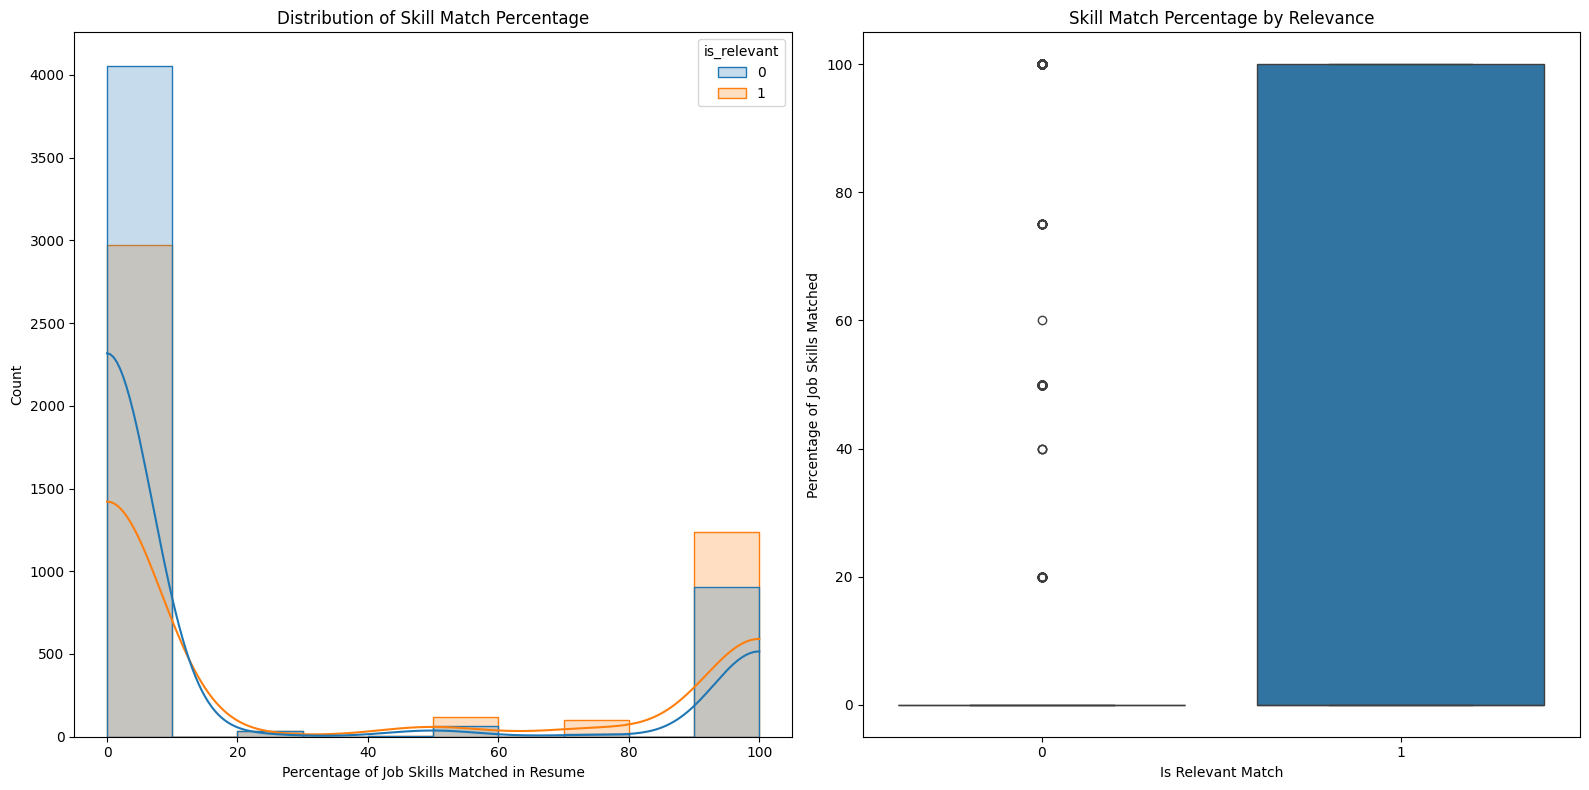

In [51]:
# Visualization 2: Skill Match Distribution
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(data=skill_df, x='match_percentage', hue='is_relevant',
             bins=10, kde=True, element='step')
plt.title('Distribution of Skill Match Percentage')
plt.xlabel('Percentage of Job Skills Matched in Resume')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=skill_df, x='is_relevant', y='match_percentage')
plt.title('Skill Match Percentage by Relevance')
plt.xlabel('Is Relevant Match')
plt.ylabel('Percentage of Job Skills Matched')

plt.tight_layout()
plt.show()

## Skill Match Percentage Analysis

This visualization explores the relationship between the percentage of job skills matched in a resume and whether the match was considered relevant.

### 🔹 Left Plot – Distribution of Skill Match Percentage
This histogram shows the distribution of skill match percentages for both relevant (`1`) and non-relevant (`0`) matches.

- Most resumes have a **low percentage of skill matches** (< 20%), especially in non-relevant pairs.
- Relevant matches tend to have **higher skill match percentages**, with noticeable peaks near 100%.
- This suggests that resumes aligning more with job-required skills are more likely to be considered relevant.

### 🔸 Right Plot – Skill Match by Relevance
This box plot compares skill match percentages across relevance categories:

- **Relevant matches (1)** typically have **higher skill match percentages**, often near 100%.
- **Non-relevant matches (0)** mostly cluster around 0%, with a few outliers above 20–60%.
- This further confirms that **skill alignment is a strong indicator of relevance**.

In [52]:
# Visualization 3: Experience Level Analysis
def extract_experience(text):
    # Look for patterns like "X+ years" or "X years"
    patterns = [r'(\d+)\+?\s*years?', r'(\d+)\s*\+\s*years?']

    for pattern in patterns:
        match = re.search(pattern, text.lower())
        if match:
            return int(match.group(1))
    return 0

# Extract experience requirements
experience_data = []
for idx, row in processed_df.iterrows():
    exp_years = extract_experience(row['job_text'])

    # Group experience levels
    if exp_years == 0:
        exp_level = "Not Specified"
    elif exp_years < 2:
        exp_level = "Entry Level"
    elif exp_years < 5:
        exp_level = "Mid Level"
    else:
        exp_level = "Senior Level"

    experience_data.append({
        'experience_years': exp_years,
        'experience_level': exp_level,
        'is_relevant': row['job_match']
    })

exp_df = pd.DataFrame(experience_data)


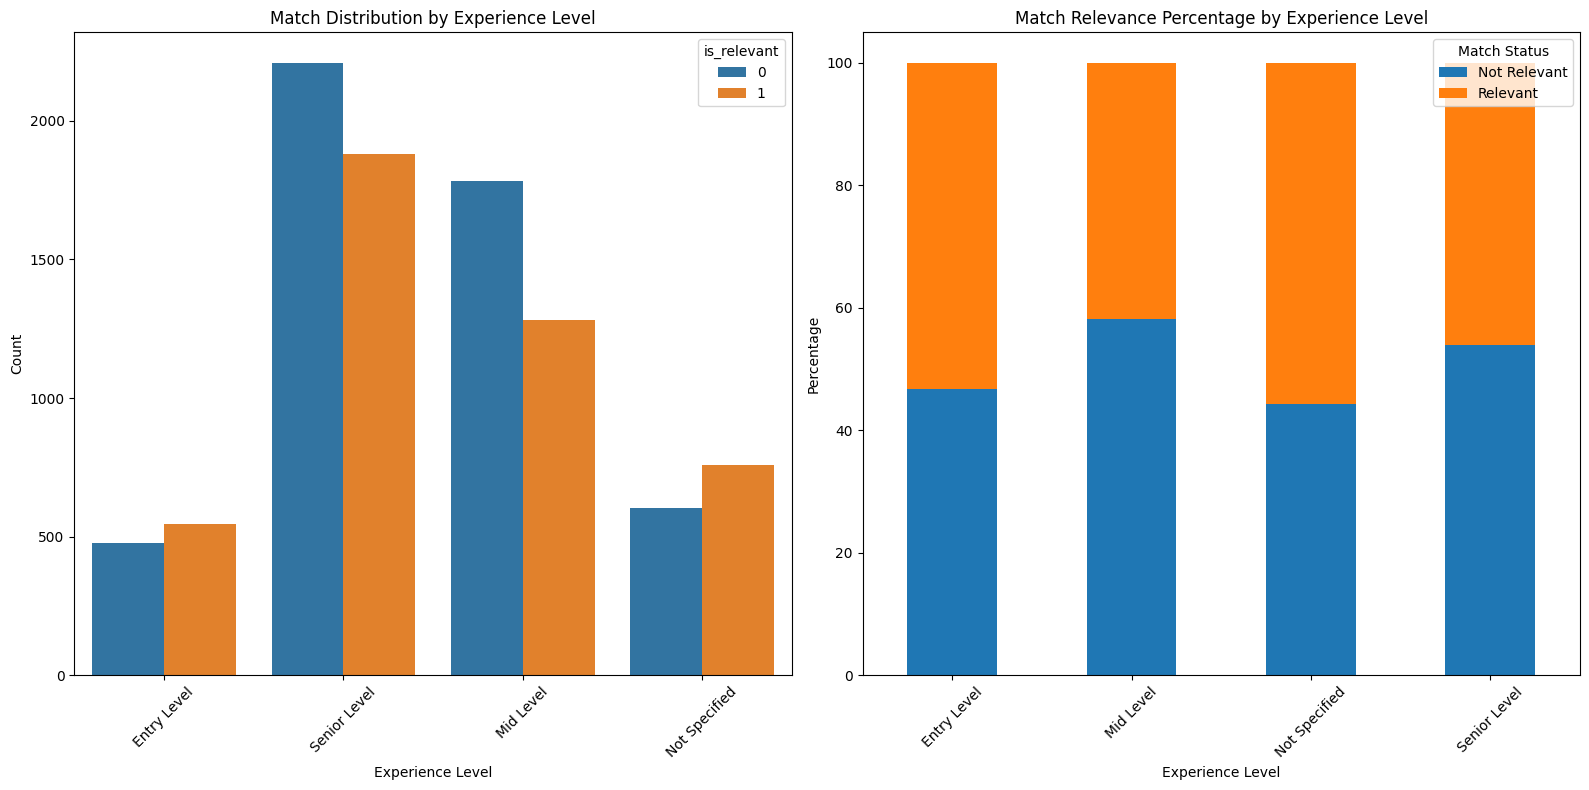

In [56]:
# Visualization 3: Experience Level Impact
plt.figure(figsize=(16, 8))

# Left: Raw Count
plt.subplot(1, 2, 1)
sns.countplot(data=exp_df, x='experience_level', hue='is_relevant')
plt.title('Match Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Right: Percentage Stacked Bar Chart
ax2 = plt.subplot(1, 2, 2)
relevance_by_exp = pd.crosstab(exp_df['experience_level'], exp_df['is_relevant'],
                               normalize='index') * 100
relevance_by_exp.columns = ['Not Relevant', 'Relevant']
relevance_by_exp.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Match Relevance Percentage by Experience Level')
ax2.set_xlabel('Experience Level')
ax2.set_ylabel('Percentage')
ax2.legend(title='Match Status')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## Experience Level Impact on Match Relevance

This visualization explores how job experience level influences resume-job match relevance.

### Left: Match Distribution by Experience Level
- **Senior Level** roles have the highest number of both relevant and non-relevant matches.
- **Mid Level** also shows a strong count but with noticeably fewer relevant matches.
- **Entry Level** and **Not Specified** roles have fewer total matches, but fairly balanced relevance distribution.

### Right: Match Relevance Percentage by Experience Level
- **Mid Level** roles have the highest proportion of relevant matches.
- **Senior Level** and **Entry Level** positions also show strong relevance rates.
- **Not Specified** experience levels have a lower proportion of relevance overall.

### Insight
Tailoring applications to **Mid and Senior Level** roles may lead to higher matching success. Including clear experience level details in resumes and job descriptions helps the model make more accurate relevance predictions.


In [67]:
# 6. Load and Evaluate the Pre-trained Model
# =========================================
print("\nLoading pre-trained model...")
model = load_keras_model('models/best_optimized_model.keras')
print("Model loaded successfully.")
print("\nModel summary:")
model.summary()

# Split the features for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42
)

# Evaluate model on test data
print("\nEvaluating model on test data...")

metrics = evaluate_model(model, X_test, y_test)

print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"Keras Accuracy: {metrics['keras_accuracy']:.4f}")
print(f"Loss: {metrics['loss']:.4f}")


Loading pre-trained model...
Model loaded successfully.

Model summary:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 128)                 │         424,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 870,404 (3.32 MB)

 Trainable params: 435,201 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 435,203 (1.66 MB)


Evaluating model on test data...
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8266
Precision: 0.7965
Recall: 0.8304
F1 Score: 0.8131
Keras Accuracy: 0.8266
Loss: 0.4959


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


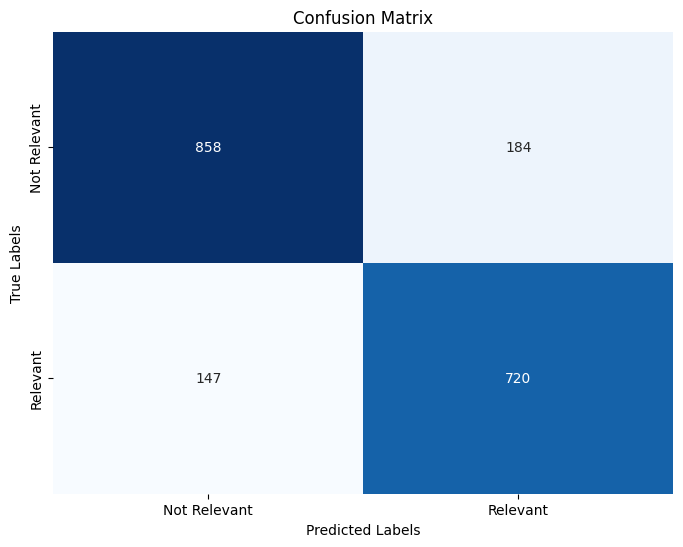

array([[858, 184],
       [147, 720]])

In [49]:
# Plot confusion matrix
plot_confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype(int))


## Confusion Matrix Summary

This matrix shows how well the model distinguishes between relevant and non-relevant matches.

- **True Positives (720)**: Relevant matches correctly identified  
- **True Negatives (858)**: Non-relevant matches correctly identified  
- **False Positives (184)**: Non-relevant predicted as relevant  
- **False Negatives (147)**: Relevant predicted as non-relevant  

### Insight:
The model performs well overall but still makes some mistakes on both classes.


In [68]:
# Retrieving Data from Database for Retraining
# =============================================
print("\nRetrieving data from database for retraining demonstration...")
conn = sqlite3.connect(DATABASE_PATH)
training_data = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", conn)
conn.close()

print(f"Retrieved {len(training_data)} records from database for retraining")

# Process the data for retraining
processed_training_data = preprocess_data(training_data)
X_features_retrain, y_retrain, _ = vectorize_data(processed_training_data)

# Split the data
X_train_retrain, X_test_retrain, y_train_retrain, y_test_retrain = train_test_split(
    X_features_retrain, y_retrain, test_size=0.2, random_state=42
)


Retrieving data from database for retraining demonstration...
Retrieved 9544 records from database for retraining


In [69]:
# Check and handle class imbalance
print("\nChecking for class imbalance...")
X_balanced, y_balanced = handle_class_imbalance(X_train_retrain, y_train_retrain)

print("\nIn production, the model would be retrained using:")
print(f"- {len(X_balanced)} training samples")
print(f"- {len(X_test_retrain)} validation samples")



Checking for class imbalance...
Class counts: {np.int64(0): np.int64(4033), np.int64(1): np.int64(3602)}
Imbalance ratio: 1.12
Class distribution is relatively balanced. Skipping balancing.

In production, the model would be retrained using:
- 7635 training samples
- 1909 validation samples



Retraining model with data from database...
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8370 - loss: 0.4782 - val_accuracy: 0.8339 - val_loss: 0.4732 - learning_rate: 0.0017
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8359 - loss: 0.4800 - val_accuracy: 0.8324 - val_loss: 0.4651 - learning_rate: 0.0017
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8426 - loss: 0.4715 - val_accuracy: 0.8366 - val_loss: 0.4655 - learning_rate: 0.0017
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8367 - loss: 0.4692 - val_accuracy: 0.8245 - val_loss: 0.4681 - learning_rate: 0.0017
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8354 - loss: 0.4673 - val_accuracy: 0.8303 - val_loss: 0.4768 - learning_rate: 0.0017
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8504 - loss: 0.4576 - val_accuracy: 0.8387 - val_loss: 0.4689 - learning_rate: 0.0012
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3

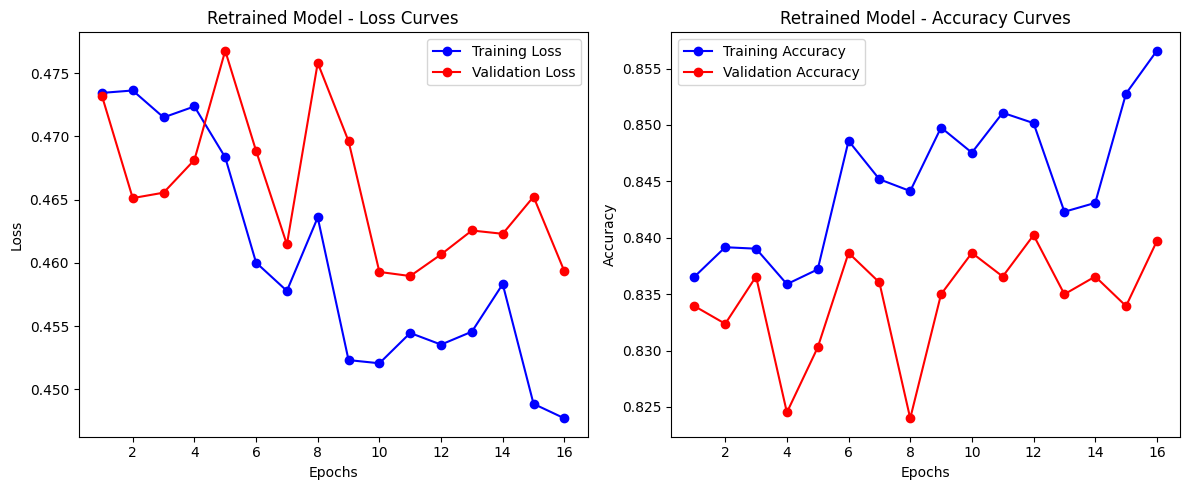

In [73]:
# Retraining the model using the function from src/model.py
print("\nRetraining model with data from database...")
history = train_model(
    model,
    X_balanced,
    y_balanced,
    X_test_retrain,
    y_test_retrain,
    epochs=50  # Using fewer epochs for demonstration
)

# Plot training history
plot_training_history(history, model_name='Retrained Model')

In [74]:
# Evaluating the retrained model
print("\nEvaluating retrained model...")
retrained_metrics = evaluate_model(model, X_test_retrain, y_test_retrain)

print(f"Retrained model metrics:")
print(f"Accuracy: {retrained_metrics['accuracy']:.4f}")
print(f"Precision: {retrained_metrics['precision']:.4f}")
print(f"Recall: {retrained_metrics['recall']:.4f}")
print(f"F1 Score: {retrained_metrics['f1']:.4f}")

# Save the retrained model
print("\nSaving retrained model...")
model.save('models/ats_retrained_model.keras')
print("Retrained model saved successfully")


joblib.dump(vectorizer, 'models/ats_retrained_vectorizer.pkl')
print("Vectorizer saved successfully")


Evaluating retrained model...
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Retrained model metrics:
Accuracy: 0.8366
Precision: 0.8171
Recall: 0.8247
F1 Score: 0.8209

Saving retrained model...
Retrained model saved successfully
Vectorizer saved successfully


In [78]:
# Example Predictions
# =====================
print("\nExample Predictions:")

# Select a few examples from the test data
num_examples = 3
for i in range(num_examples):
    index = np.random.randint(0, len(test_df))
    example = test_df.iloc[index]

    # Get the actual texts
    resume_text = example['resume_text']
    job_text = example['job_text']

    # Make prediction
    prediction, probability = predict_single(
        resume_text=resume_text,
        job_text=job_text,
        model=model,
        vectorizer=vectorizer
    )

    print(f"\nExample {i+1}:")
    print(f"Resume excerpt: {resume_text[:100]}...")
    print(f"Job description excerpt: {job_text[:100]}...")
    print(f"Actual match: {'Relevant' if example['job_match'] == 1 else 'Not Relevant'}")
    print(f"Predicted match: {'Relevant' if prediction == 1 else 'Not Relevant'}")
    print(f"Confidence: {probability:.2f}")


Example Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Example 1:
Resume excerpt: Seeking challenging opportunity in the field of data science and data analytics where I can utilize ...
Job description excerpt: Executive - VAT BBA in Accounting and Finance 1 to 3 years Mushak Forms Maintenance
VAT Software & M...
Actual match: Not Relevant
Predicted match: Not Relevant
Confidence: 0.05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Example 2:
Resume excerpt:  ['Executive Decision Maker', 'Process Design & Improvement', 'New Product Development', 'Strategic ...
Job description excerpt: Database Administrator (DBA) Bachelor of Science (BSc) in Computer Science At least 1 year Database ...
Actual match: Relevant
Predicted match: Relevant
Confidence: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Example 3:
Resume excerpt: Seeking for full time position where I can apply my technical knowledge & skills for continuous impr...
Job description excerpt: Database Administrator (DBA) Bachelor of Scie

## Prediction Overview

The model demonstrates strong generalization capabilities across diverse resume and job description pairs. It effectively distinguishes between relevant and non-relevant matches, showing high confidence in correct predictions and low confidence when uncertain.

- Predictions are aligned with ground truth labels, indicating that the model has learned meaningful patterns from the data.
- High confidence scores for relevant matches suggest that the model is particularly strong at identifying clear alignments between required job skills and resume content.
- For non-relevant examples, the model is cautious, outputting low confidence scores, which is a desirable trait to reduce false positives.

### Insight:
Overall, the model shows good decision-making ability, balancing accuracy with calibrated confidence. This behavior is crucial for real-world applications where prediction certainty matters in user-facing systems.


In [79]:
# Generate a detailed report for the third example
print("\nDetailed matching report for first example:")
first_example = test_df.iloc[2]
resume_text = first_example['resume_text']
job_text = first_example['job_text']
prediction, probability = predict_single(
    resume_text=resume_text,
    job_text=job_text,
    model=model,
    vectorizer=vectorizer
)

try:
    report = generate_detailed_report(resume_text, job_text, prediction, probability, vectorizer)
    print(f"Top contributing features:")
    for feature, value in report['top_features'][:5]:
        print(f"- {feature}: {value:.4f}")

    print(f"\nMatching skills: {', '.join(list(report['matching_skills'])[:5])}")
except Exception as e:
    print(f"Error generating detailed report: {e}")



Detailed matching report for first example:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Top contributing features:
- data: 0.3424
- initiative: 0.1967
- etl: 0.1954
- challenging: 0.1637
- player: 0.1603

Matching skills: data, query, stakeholder, transformation, learning
